# "Laplacian Matrix Learning for Smooth Graph Signal Representation" [Dong et al., 2015]

In [469]:
from scipy import spatial
from sklearn import metrics
import pygsp
import utils
import learn_graph as lg
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
import cvxopt
import copy
%matplotlib inline

## Generate ground truth graph

In [470]:
N = 256 # Number of nodes
Ne = (N * (N - 1)) // 2 # number of edges

D = 4 # dimension of signal

G = pygsp.graphs.Sensor(N)

W_gt = G.W.toarray()

pos = G.coords

G_nx = nx.from_numpy_matrix(W_gt)

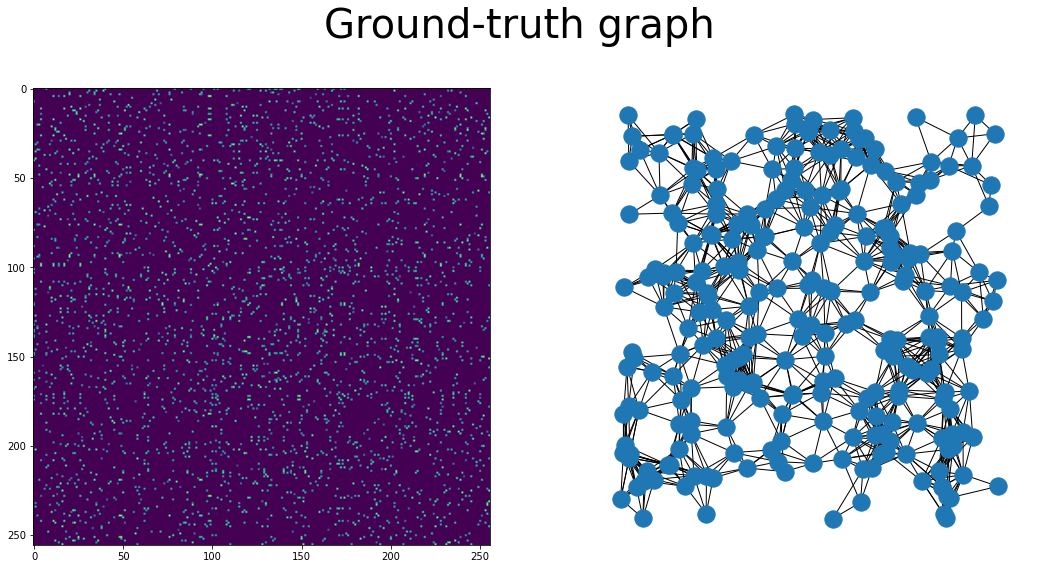

In [471]:
plt.figure(figsize=(18, 9))
plt.suptitle('Ground-truth graph', fontsize=40)

plt.subplot(1,2,1)
plt.imshow(W_gt)

plt.subplot(1,2,2)
nx.draw(G_nx, pos=pos)

## Generate samples

In [472]:
def s1(x, y): 
    return np.sin((2 - x - y)**2) 
def s2(x, y): 
    return np.cos((x + y)**2)
def s3(x, y): 
    return (x - 0.5)**2 + (y - 0.5)**3 + x - y 
def s4(x, y): 
    return np.sin(3 * ( (x - 0.5)**2 + (y - 0.5)**2 ) )

X = 5 * np.array((s1(G.coords[:,0], G.coords[:,1]), 
                  s2(G.coords[:,0], G.coords[:,1]), 
                  s3(G.coords[:,0], G.coords[:,1]), 
                  s4(G.coords[:,0], G.coords[:,1]))).T


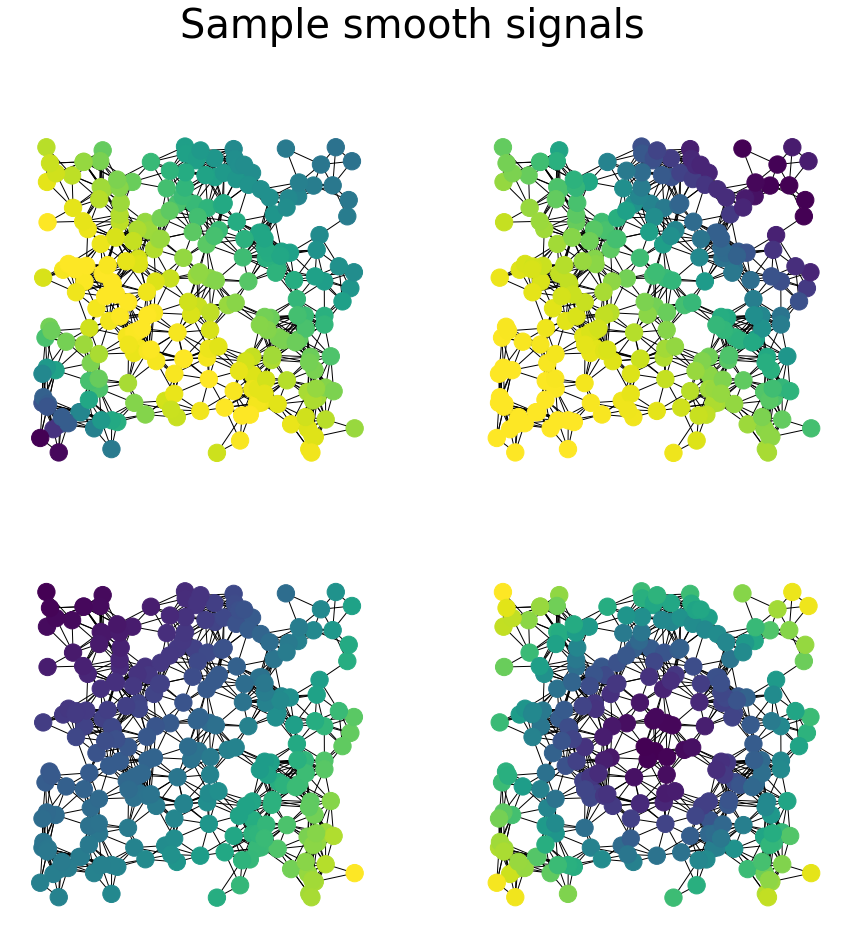

In [512]:
plt.figure(figsize=(15, 15))
plt.suptitle('Sample smooth signals', fontsize=40)

plt.subplot(2,2,1)
nx.draw(G_nx, pos=pos, node_color=X[:,0])

plt.subplot(2,2,2)
nx.draw(G_nx, pos=pos, node_color=X[:,1])

plt.subplot(2,2,3)
nx.draw(G_nx, pos=pos, node_color=X[:,2])

plt.subplot(2,2,4)
nx.draw(G_nx, pos=pos, node_color=X[:,3])

## Solve the optimization problem

In [513]:
# remove points at random

f = 0.1 # fraction of points that are unavailable

missing_at_feature = [[] for i in range(D)]
sample_n_d_points = [random.randint(0, D - 1) for i in range(int(f * N * D))]
frequency = {i : min(N, sample_n_d_points.count(i)) for i in range(D)}
for feature_id in range(D):
    missing_at_feature[feature_id] = list(map(
            lambda x: (feature_id, x),
            sorted(random.sample(range(N), frequency[feature_id]))
        ))
missing = []
for l in missing_at_feature:
    missing.extend(l)
variable_id = {}
i = 0
for x in missing:
    variable_id[x] = i
    i += 1

In [514]:
# print(missing_at_feature)
# print(missing)
# print(variable_id)

In [538]:
def solve(X_input, N, D, missing_list, missing_at_feature, variable_id, ITER):
    
    W_imputed, problem_imputed, x_unknown = None, None, None
    
    X_imputed = copy.deepcopy(X_input)
    
    # initialization
    average = [0 for i in range(D)]
    feature_missing_matrix = []
    total_missing = len(missing_list)
    
    for feature_id in range(D):
        missing = [False for i in range(N)]
        for _, i in missing_at_feature[feature_id]:
            missing[i] = True
        feature_missing_matrix.append(missing)
        cnt, total = 0, 0
        choices = []
        for i in range(N):
            if not missing[i]:
                cnt += 1
                total += X_imputed[i][feature_id]
                choices.append(X_imputed[i][feature_id])
        if cnt != 0:
            average[feature_id] = total / cnt
            
        for _, i in missing_at_feature[feature_id]:
            X_imputed[i][feature_id] = average[feature_id]
            # X_imputed[i][feature_id] = random.choice(choices)
    
    last_objective = float('inf')
    
    from collections import defaultdict
    for iteration in range(ITER):
        W_imputed, problem_imputed =\
            lg.l2_degree_reg(X_imputed, dist_type='sqeuclidean', alpha=1, s=N, retall=True)
        # now write the optimization problem
        deg_2_values = defaultdict(float)
        deg_1_values = [0 for i in range(total_missing)]
        constant = 0
        for feature_id in range(D):
            missing = feature_missing_matrix[feature_id]
            for i in range(N):
                if missing[i]:
                    pos_i = variable_id[(feature_id, i)]
                    for j in range(i + 1, N):
                        w_ij = max(0, W_imputed[i][j])
                        if missing[j]:
                            pos_j = variable_id[(feature_id, j)]
                            # w_ij (x_pos_i - x_pos_j)**2
                            deg_2_values[(pos_i, pos_i)] += w_ij
                            deg_2_values[(pos_i, pos_j)] -= w_ij
                            deg_2_values[(pos_j, pos_i)] -= w_ij
                            deg_2_values[(pos_j, pos_j)] += w_ij
                        else:
                            # w_ij (x_pos_i - X[j][feature_id]) ** 2
                            deg_2_values[(pos_i, pos_i)] += w_ij
                            deg_1_values[pos_i] -= 2 * w_ij * X_imputed[j][feature_id]
                            constant += w_ij * (X_imputed[j][feature_id] ** 2)
                else:
                    for j in range(i + 1, N):
                        w_ij = max(0, W_imputed[i][j])
                        if missing[j]:
                            pos_j = variable_id[(feature_id, j)]
                            deg_2_values[(pos_j, pos_j)] += w_ij
                            deg_1_values[pos_j] -= 2 * w_ij * X_imputed[i][feature_id]
                            constant += w_ij * (X_imputed[i][feature_id] ** 2)
                        else:
                            constant += w_ij * ((X_imputed[i][feature_id] - X_imputed[j][feature_id]) ** 2)
                            
        P_val = [z for ((x, y), z) in deg_2_values.items()]
        P_row = [x for ((x, y), z) in deg_2_values.items()]
        P_col = [y for ((x, y), z) in deg_2_values.items()]
        P = 2 * cvxopt.spmatrix(P_val, P_row, P_col, (total_missing, total_missing))
        q = cvxopt.matrix(deg_1_values)
        try: sol = cvxopt.solvers.qp(P, q)
        except: break
        x_unknown = (np.array(sol['x']).T)[0]
        for i in range(total_missing):
            I, J = missing_list[i]
            X_imputed[J][I] = x_unknown[i]
        cur_objective = constant + sol['primal objective']
        if abs(last_objective - cur_objective) / cur_objective < 1e-4:
            break
        last_objective = cur_objective
    print(iteration)
    return W_imputed, problem_imputed, X_imputed

In [549]:
W_imputed, problem_imputed, X_imputed = solve(X, N, D, missing, missing_at_feature, variable_id, 10)
W_imputed = np.maximum(W_imputed, 0)
W_imputed[W_imputed < 1e-4] = 0

9


In [550]:
W, problem = lg.l2_degree_reg(X, dist_type='sqeuclidean', alpha=1, s=N, retall=True)
W = np.maximum(W, 0)
W[W < 1e-4] = 0

In [551]:
np.sqrt(np.sum(((X - X_imputed)**2).T, axis=1) / np.array([max(1, len(temp)) for temp in missing_at_feature]))

array([0.95687178, 2.10343733, 1.74535417, 0.770285  ])

In [552]:
np.sum((W - W_imputed)**2)/(N * D)

0.022293953277654172

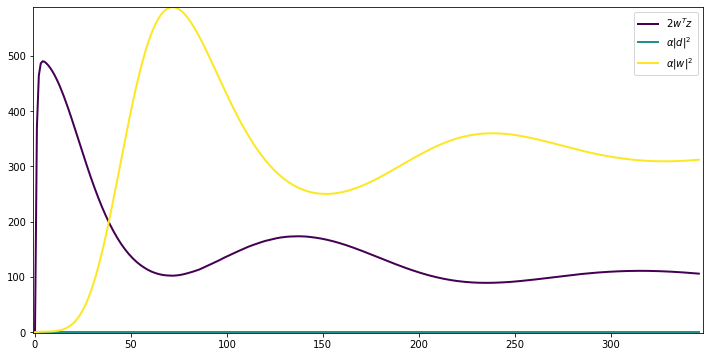

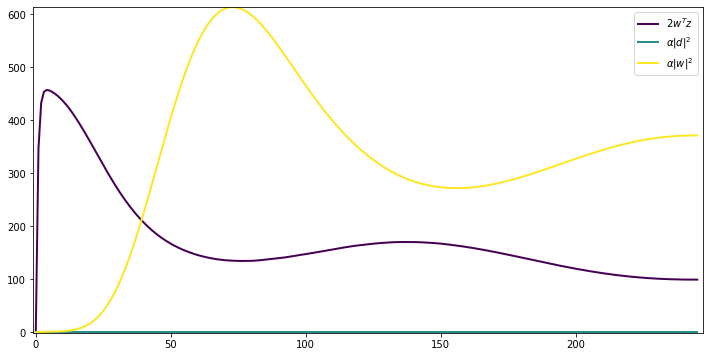

In [553]:
# Display objective values
fig, ax = utils.plot_objectives(problem['objective'], 
                                labels=[r'$2 w^T z$', 
                                        r'$\alpha \|d\|^2$',
                                        r'$\alpha \|w\|^2$'])
#ax.set_xlim([-1, 100])
#ax.set_ylim([-500, 2500])
plt.show()

fig, ax = utils.plot_objectives(problem_imputed['objective'], 
                                labels=[r'$2 w^T z$', 
                                        r'$\alpha \|d\|^2$',
                                        r'$\alpha \|w\|^2$'])
#ax.set_xlim([-1, 100])
#ax.set_ylim([-500, 2500])
plt.show()

## Recover learned graph

In [554]:
W_thresh = np.max(W_gt) * W / np.max(W)
W_thresh[W_thresh < 0.1 * np.max(W_gt)] = 0
G_learned = nx.from_numpy_matrix(W_thresh)

W_imputed_thresh = np.max(W_gt) * W_imputed / np.max(W_imputed)
W_imputed_thresh[W_imputed_thresh < 0.1 * np.max(W_gt)] = 0
G_learned_imputed = nx.from_numpy_matrix(W_imputed_thresh)

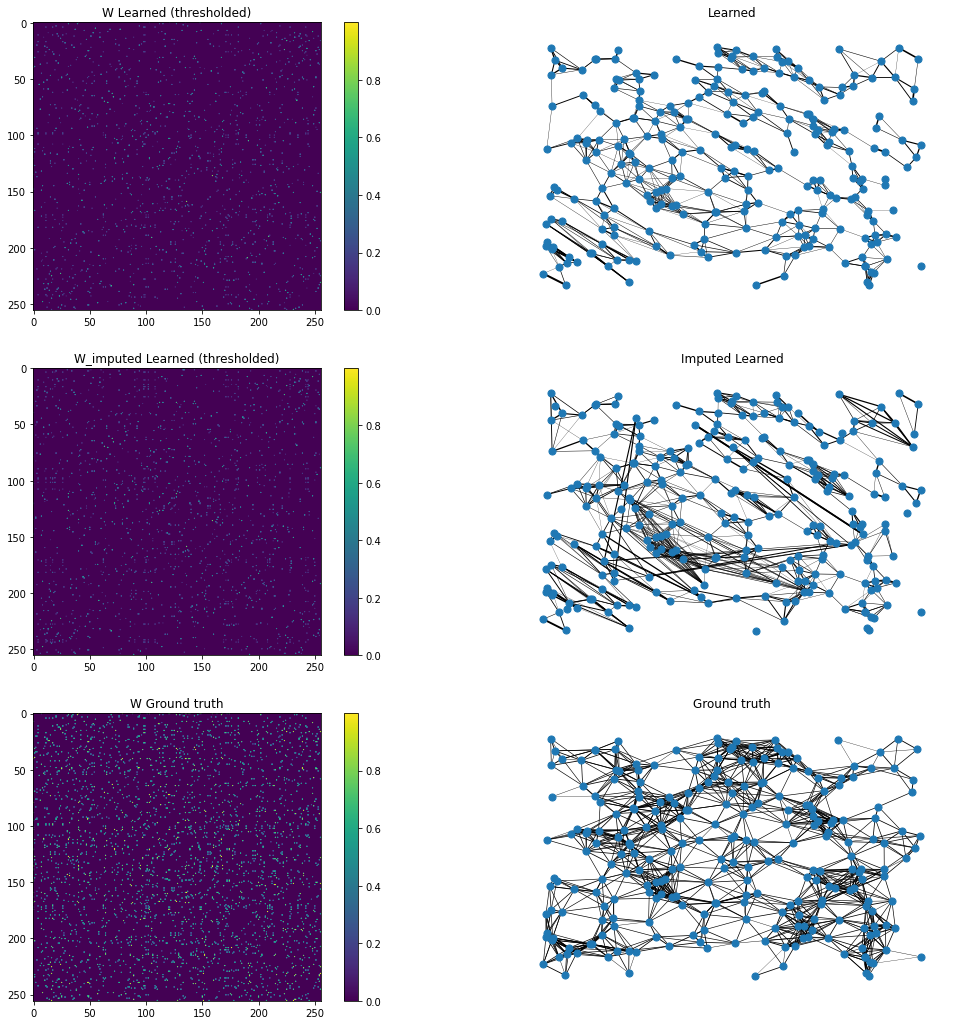

In [555]:
NODE_SIZE = 50
FACTOR = 2

plt.figure(figsize=(18, 18))
plt.subplot(3,2,1)
plt.imshow(W_thresh)
plt.colorbar()
plt.title('W Learned (thresholded)')

plt.subplot(3,2,2)
edge_wts = [FACTOR * W_thresh[edge[0], edge[1]] for edge in G_learned.edges()]
nx.draw(G_learned, pos=pos, node_size=NODE_SIZE, width=edge_wts)
plt.title('Learned')




# plt.figure(figsize=(18, 18))
plt.subplot(3,2,3)
plt.imshow(W_imputed_thresh)
plt.colorbar()
plt.title('W_imputed Learned (thresholded)')

plt.subplot(3,2,4)
edge_wts = [FACTOR * W_imputed_thresh[edge[0], edge[1]] for edge in G_learned_imputed.edges()]
nx.draw(G_learned_imputed, pos=pos, node_size=NODE_SIZE, width=edge_wts)
plt.title('Imputed Learned')




# plt.figure(figsize=(18, 18))
plt.subplot(3,2,5)
plt.imshow(W_gt)
plt.colorbar()
plt.title('W Ground truth')

FACTOR /= 2

plt.subplot(3,2,6)
edge_wts = [FACTOR * W_gt[edge[0], edge[1]] for edge in G_nx.edges()]
nx.draw(G_nx, pos=pos, node_size=NODE_SIZE, width=edge_wts)
plt.title('Ground truth')

plt.show()

In [556]:
f_score = metrics.f1_score(
                            (spatial.distance.squareform(copy.deepcopy(W_gt)) > 0),
                            (spatial.distance.squareform(copy.deepcopy(W)) > 0)
)

f_score_imputed = metrics.f1_score(
                            (spatial.distance.squareform(copy.deepcopy(W_gt)) > 0), 
                            (spatial.distance.squareform(copy.deepcopy(W_imputed)) > 0)
)

print("F-score (no imputation) = {:.2f}".format(f_score))
print("F-score (imputation) = {:.2f}".format(f_score_imputed))

F-score (no imputation) = 0.69
F-score (imputation) = 0.61


## Compare spectra of the Laplacian matrices

In [557]:
L = utils.create_laplacian(W, lap_type='normalized', 
                           sparse_flag=False)
L_imputed = utils.create_laplacian(W_imputed, lap_type='normalized', 
                           sparse_flag=False)
L_gt = utils.create_laplacian(W_gt, lap_type='normalized', 
                           sparse_flag=False)

e, _ = np.linalg.eigh(L)
e = np.sort(e)

e_gt, _ = np.linalg.eigh(L_gt)
e_gt = np.sort(e_gt)

e_imputed, _ = np.linalg.eigh(L_imputed)
e_imputed = np.sort(e_imputed)

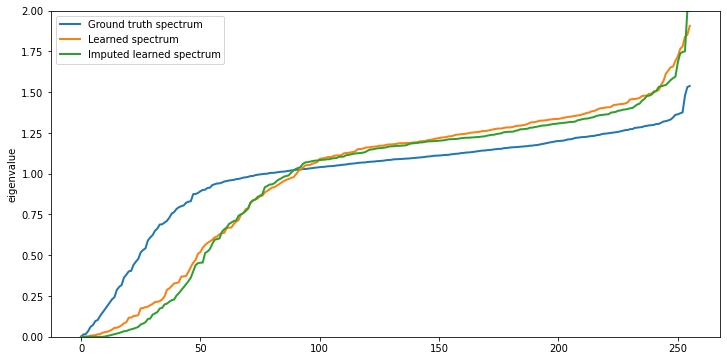

In [558]:
plt.figure(figsize=(12, 6))
plt.plot(e_gt, linewidth=2)
plt.plot(e, linewidth=2)
plt.plot(e_imputed, linewidth=2)
plt.ylabel('eigenvalue')
plt.ylim([0,max(np.max(e_gt), np.max(e), np.max(e_imputed))])
plt.legend(['Ground truth spectrum', 'Learned spectrum', 'Imputed learned spectrum'], loc='best')

plt.show()